# Description

Dashboard to access results for the CPM portion of the analyses.

In [62]:
import pandas as pd
import os.path as osp
from utils.basics import RESOURCES_CPM_DIR
import hvplot.pandas
from tqdm import tqdm
import holoviews as hv
import xarray as xr
import numpy as np
import pickle
from utils.basics import get_sbj_scan_list, FB_400ROI_ATLAS_NAME, FB_200ROI_ATLAS_NAME, ATLASES_DIR
from cpm.plotting import plot_predictions
import seaborn as sns
import panel as pn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from statannot import add_stat_annotation
from scipy.spatial.distance import squareform
from utils.plotting import plot_as_circos, hvplot_fc_nwlevel, plot_as_graph
from nilearn.plotting import view_connectome, plot_connectome
from nxviz.utils import node_table
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

In [45]:
def create_unimodal_graph_from_matrix(data):
    assert isinstance(data,pd.DataFrame),    "++ERROR [plot_as_graph]:  input data expected to be a pandas dataframe"
    assert 'ROI_ID'     in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named ROI_ID"
    assert 'Hemisphere' in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Hemisphere"
    assert 'Network'    in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Network"
    assert 'RGB'    in data.index.names,     "++ERROR [plot_as_graph]: input data expected to have one column named RGB"
    
    # Convert input to ints (this function only works for unweigthed graphs)
    fdata          = data.copy().astype('int')
    fdata.index    = fdata.index.get_level_values('ROI_ID')
    fdata.columns  = fdata.index
    
    # Create basic Graph
    # ==================
    G = nx.from_pandas_adjacency(fdata)
    
    # Add information about hemisphere and network
    # ============================================
    hemi_attribs      = {row['ROI_ID']:row['Hemisphere'] for r,row in roi_info.iterrows()}
    nw_attribs        = {row['ROI_ID']:row['Network'] for r,row in roi_info.iterrows()}
    lab_attribs       = {row['ROI_ID']:row['ROI_Name'] for r,row in roi_info.iterrows()}
    col_attribs       = {row['ROI_ID']:row['RGB'] for r,row in roi_info.iterrows()}
    id_attribs        = {row['ROI_ID']:row['ROI_ID'] for r,row in roi_info.iterrows()}
    deg_attribs          = nx.degree_centrality(G)
    degree_centr_attribs = {r:v for r,v in zip(list(deg_attribs.keys()), MinMaxScaler(feature_range=(0.001,0.01)).fit_transform(np.array(list(nx.degree_centrality(G).values())).reshape(-1,1)).flatten())}
    degree_attribs       = dict(G.degree())
    nx.set_node_attributes(G,hemi_attribs,'Hemisphere')
    nx.set_node_attributes(G,nw_attribs,'Network')
    nx.set_node_attributes(G,lab_attribs,'ROI_Name')
    nx.set_node_attributes(G,id_attribs,'ROI_ID')
    nx.set_node_attributes(G,col_attribs,'RGB')
    nx.set_node_attributes(G,degree_centr_attribs,'Degree_Centrality')
    nx.set_node_attributes(G,degree_attribs,'Degree')
    nx.set_node_attributes(G,nx.eigenvector_centrality(G),'Eigenvector_Centrality')
    nx.set_node_attributes(G,nx.pagerank(G),'Page_Rank')

    # Add edge attributes based on which model they represent
    # =======================================================
    # Count the input values
    val_counts = pd.Series(fdata.values.flatten()).value_counts()
    # Check for the presence of positive edges
    if 1 in val_counts.index:
        #fdata_pos will have 1s for edges in positive model, zero anywhere else
        fdata_pos              = fdata.copy()
        fdata_pos[fdata_pos<0] = 0 # Removing -1 from positive graph
        G_pos = nx.from_pandas_adjacency(fdata_pos)
    model_attribs = {}
    if G_pos is not None:
        for edge in G_pos.edges:
            model_attribs[edge] = 'pos'
    nx.set_edge_attributes(G,model_attribs,'Model')
    
    return G

In [2]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 43194


In [3]:
ACCURACY_METRIC      = 'pearson'
CORR_TYPE            = 'pearson'
E_SUMMARY_METRIC     = 'sum'
CONFOUNDS            = 'conf_residualized'
BEHAVIOR_LIST        = ['Factor1','Factor2','Vigilance','Images','Words','People','Myself','Positive','Negative','Surroundings','Intrusive','Future','Past','Specific']
SPLIT_MODE           = 'subject_aware'
ATLAS                = FB_400ROI_ATLAS_NAME
CPM_NITERATIONS      = 100
CPM_NULL_NITERATIONS = 10000

***

# 1. CPM Predictions

## 1.1. Load the results from swarm jobs

### 1.1.1 Real data

In [4]:
real_results_path = osp.join(RESOURCES_CPM_DIR,f'real-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')
with open(real_results_path,'rb') as f:
     real_predictions_xr = pickle.load(f)
Nbehavs, Niters_real, Nscans, Nresults = real_predictions_xr.shape
print(Nbehavs, Niters_real, Nscans, Nresults)

14 100 471 4


### 1.1.2. Randomized data

In [5]:
#null_results_path = osp.join(RESOURCES_CPM_DIR,f'null-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')
null_results_path = osp.join(RESOURCES_CPM_DIR,f'null-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')

with open(null_results_path,'rb') as f:
     null_predictions_xr = pickle.load(f)
_, Niters_null, _, _ = null_predictions_xr.shape


## 1.2. Compute Accuracy

### 1.2.1. Real data

In [6]:
%%time
accuracy_real = {BEHAVIOR:pd.DataFrame(index=range(Niters_real), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LIST}

p_values = pd.DataFrame(index=BEHAVIOR_LIST,columns=['Non Parametric','Parametric'])

for BEHAVIOR in BEHAVIOR_LIST:
    for niter in tqdm(range(Niters_real), desc=BEHAVIOR):
        observed  = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_real[BEHAVIOR].loc[niter]  = observed.corr(predicted, method=ACCURACY_METRIC)
        if ACCURACY_METRIC == 'pearson':
            _,p_values.loc[BEHAVIOR,'Parametric'] = pearsonr(observed,predicted)
        if ACCURACY_METRIC == 'spearman':
            _,p_values.loc[BEHAVIOR,'Parametric'] = spearmanr(observed,predicted)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 738.40it/s]

CPU times: user 1.93 s, sys: 30.6 ms, total: 1.97 s
Wall time: 1.98 s


### 1.2.2. Randomized data

In [7]:
%%time
accuracy_null = {BEHAVIOR:pd.DataFrame(index=range(Niters_null), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LIST}
for BEHAVIOR in BEHAVIOR_LIST:
    for niter in tqdm(range(Niters_null), desc=BEHAVIOR):
        observed  = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_null[BEHAVIOR].loc[niter]  = observed.corr(predicted, method=ACCURACY_METRIC)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 843.41it/s]

CPU times: user 2min 45s, sys: 901 ms, total: 2min 46s
Wall time: 2min 46s


## 1.3. Compute Non-parameter p-values

For this, we rely on the null distribution generated via label randomization. 

We use the formula on section 2.4.4 from Finn & Bandettini ["Movie-watching outperforms rest for functional connectivity-based prediction of behavior"](https://www.sciencedirect.com/science/article/pii/S1053811921002408) NeuroImage 2021

In [8]:
p_values.columns.name = 'p-value'
for BEHAVIOR in BEHAVIOR_LIST:
    p_values.loc[BEHAVIOR,'Non Parametric'] = (((accuracy_null[BEHAVIOR] > accuracy_real[BEHAVIOR].median()).sum() + 1) / (Niters_null+1)).values[0]

## 1.4. Generate Summary Figures with all prediction targets

In [9]:
%%time
null_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LIST:
    for i in tqdm(range(Niters_null), desc=BEHAVIOR):
        null_df = null_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_null[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.91it/s]

CPU times: user 5min 6s, sys: 679 ms, total: 5min 7s
Wall time: 5min 7s


In [10]:
%%time
real_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LIST:
    for i in tqdm(range(Niters_real), desc=BEHAVIOR):
        real_df = real_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_real[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 688.08it/s]

CPU times: user 2.02 s, sys: 16 ms, total: 2.03 s
Wall time: 2.02 s


Text(0.5, 0, 'SNYCQ Item')

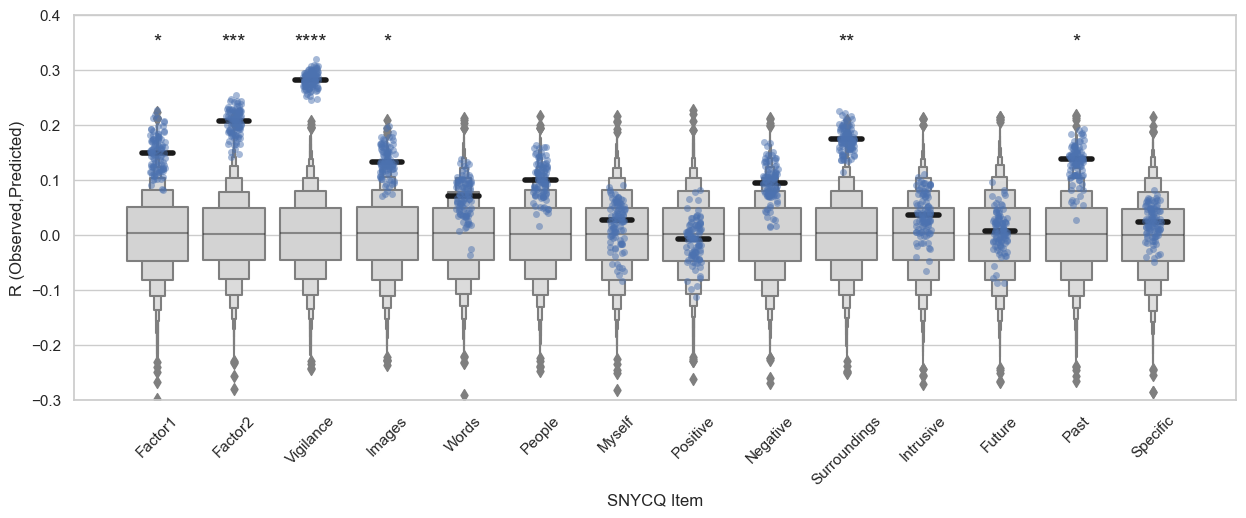

In [11]:
median_width = 0.4
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxenplot(data=null_df,x='Question',y='R', color='lightgray', ax=ax) 
sns.stripplot(data=real_df,x='Question', y='R', alpha=.5, ax=ax)
plt.xticks(rotation=45);
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax.annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax.set_ylim(-.3,.4)
ax.set_ylabel('R (Observed,Predicted)');
ax.set_xlabel('SNYCQ Item')

## 1.5. Dashboard CPM Prediction Functions

In [12]:
def get_boxen_plot(behavior):
    median_width = 0.4
    sns.set(style='whitegrid')
    fig,ax = plt.subplots(1,1,figsize=(1,5))
    sns.boxenplot(data=null_df[null_df['Question']==behavior],x='Question',y='R', color='lightgray', ax=ax) 
    sns.stripplot(data=real_df[real_df['Question']==behavior],x='Question', y='R', alpha=.5, ax=ax)
    plt.xticks(rotation=0);
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        # Add Black Line Signaling Median
        question   = text.get_text()
        median_val = accuracy_real[question].median().values[0]
        ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
        # Statistical Significant Information
        p = p_values.loc[question,'Non Parametric']
        if 5.00e-02 < p <= 1.00e+00:
            annot = '' 
        elif 1.00e-02 < p <= 5.00e-02:
            annot = '*'
        elif 1.00e-03 < p <= 1.00e-02:
            annot = '**'
        elif 1.00e-04 < p <= 1.00e-03:
            annot = '***'
        elif p <= 1.00e-04:
            annot = '****'
        max_val = real_df.set_index('Question').max()['R']
        ax.annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    ax.set_ylim(-.3,.4)
    ax.set_ylabel('R (Observed,Predicted)');
    ax.set_xlabel('')
    #ax.yaxis.get_label().set_visible(True)
    plt.close()
    plt.tight_layout()
    return fig

In [13]:
def get_obs_vs_pred(behavior):
    behav_obs_pred = pd.DataFrame(real_predictions_xr.median(dim='Iteration').loc[behavior,:,['observed','predicted (glm)']], 
                                  columns=['observed','predicted (glm)'])
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    r,p = plot_predictions(behav_obs_pred, ax=ax,
                       xlabel='Observed [%s]' % behavior, 
                       ylabel='Predicted [%s]' % behavior, 
                       font_scale=1,p_value=p_values.loc[behavior,'Non Parametric'])
    plt.close()
    return fig

***
# 2. CPM Network Models

First, we just load one model as a reference to infer the number of edges. We need this to create empty datastructures that will subsequently populate

In [14]:
ref_path = osp.join(RESOURCES_CPM_DIR,'swarm_outputs','real',ATLAS,SPLIT_MODE, CONFOUNDS,CORR_TYPE+'_'+E_SUMMARY_METRIC,'Images','cpm_Images_rep-{r}.pkl'.format(r=str(1).zfill(5)))
with open(ref_path,'rb') as f:
    ref_data = pickle.load(f)
n_edges = ref_data['models']['pos'].shape[1]

## 2.1. Load ROI Information

Next, we load the dtaframe with information about the different ROIs: labels, network membership, centroid, color

In [15]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS,f'{ATLAS}.roi_info.csv')
roi_info       = pd.read_csv(ATLASINFO_PATH)

And get a list of available networks

In [16]:
nw_list = list(roi_info['Network'].unique())
print(nw_list)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical']


## 2.2. Load models for all prediction targets

In [17]:
%%time
models = {}
models_to_vis = {}
for BEHAVIOR in BEHAVIOR_LIST:
    models = {(BEHAVIOR,'pos'):pd.DataFrame(index=range(CPM_NITERATIONS), columns=range(n_edges)),
              (BEHAVIOR,'neg'):pd.DataFrame(index=range(CPM_NITERATIONS), columns=range(n_edges))}
    df = pd.DataFrame(index=range(CPM_NITERATIONS),columns=['pos','neg','glm'])
    for r in tqdm(range(CPM_NITERATIONS), desc='Iteration [%s]' % BEHAVIOR):
        path = osp.join(RESOURCES_CPM_DIR,'swarm_outputs','real',ATLAS,SPLIT_MODE, CONFOUNDS,CORR_TYPE+'_'+E_SUMMARY_METRIC,BEHAVIOR,'cpm_{b}_rep-{r}.pkl'.format(b=BEHAVIOR,r=str(r+1).zfill(5)))
        with open(path,'rb') as f:
            data = pickle.load(f)
        # We first averaged the number of times an edge was selected within each 10-fold run (resulting in a number between 0 and 1 for each edge)
        for tail in ['pos','neg']:
            models[BEHAVIOR,tail].loc[r,:] = data['models'][tail].mean(axis=0)
    # and then averaged those fractions across all 100 train-test split iterations
    models_to_vis[BEHAVIOR,'pos'] = models[BEHAVIOR,'pos'].mean()   
    models_to_vis[BEHAVIOR,'neg'] = models[BEHAVIOR,'neg'].mean()   

data_to_disk = {'models':models, 'models_to_vis':models_to_vis}
out_path     = '../resources/cpm/plot_tmp/models.pkl'
with open(out_path,'wb') as f:
    pickle.dump(data_to_disk,f)

Iteration [Specific]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.54it/s]


CPU times: user 4min 19s, sys: 13.2 s, total: 4min 33s
Wall time: 5min 48s


In [18]:
out_path     = '../resources/cpm/plot_tmp/models.pkl'
with open(out_path,'rb') as f:
    data_to_disk = pickle.load(f)
models = data_to_disk['models']
models_to_vis = data_to_disk['models_to_vis']
del data_to_disk

## 2.3. Compute consensus models for plotting

In [19]:
thresh           = 0.9
model_consensus,num_edges_toshow,model_consensus_to_plot  = {},{},{}
for BEHAVIOR in BEHAVIOR_LIST:
    for tail in ['pos','neg']:
        edge_frac                       = models_to_vis[BEHAVIOR,tail]
        model_consensus[BEHAVIOR,tail]  = (edge_frac>=thresh).astype(int)
        num_edges_toshow[BEHAVIOR,tail] = model_consensus[BEHAVIOR,tail].sum()
        print("For the [{behav},{tail}], {edges} edges were selected in at least {pct}% of folds".format(behav=BEHAVIOR,tail=tail, edges=num_edges_toshow[BEHAVIOR,tail], pct=thresh*100))
    model_consensus_to_plot[BEHAVIOR] = pd.DataFrame(squareform(model_consensus[BEHAVIOR,'pos'])-squareform(model_consensus[BEHAVIOR,'neg']),
                          index = roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index,
                          columns= roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index)

For the [Factor1,pos], 159 edges were selected in at least 90.0% of folds
For the [Factor1,neg], 839 edges were selected in at least 90.0% of folds
For the [Factor2,pos], 1247 edges were selected in at least 90.0% of folds
For the [Factor2,neg], 479 edges were selected in at least 90.0% of folds
For the [Vigilance,pos], 1989 edges were selected in at least 90.0% of folds
For the [Vigilance,neg], 1768 edges were selected in at least 90.0% of folds
For the [Images,pos], 279 edges were selected in at least 90.0% of folds
For the [Images,neg], 566 edges were selected in at least 90.0% of folds
For the [Words,pos], 129 edges were selected in at least 90.0% of folds
For the [Words,neg], 1190 edges were selected in at least 90.0% of folds
For the [People,pos], 88 edges were selected in at least 90.0% of folds
For the [People,neg], 922 edges were selected in at least 90.0% of folds
For the [Myself,pos], 1737 edges were selected in at least 90.0% of folds
For the [Myself,neg], 20 edges were sel

***
# 3. Create Dashboard

1. Estimate the limits for the colorbar in the NW summary view (connection count mode)

In [160]:
max_counts = []
for BEHAVIOR in BEHAVIOR_LIST:
    a = model_consensus_to_plot[BEHAVIOR].abs().groupby('Network').sum().T.groupby('Network').sum()
    for n in a.index:
        a.loc[n,n] = int(a.loc[n,n]/2)
    max_counts.append(a.max().max())
max_counts = np.array(max_counts)
nw_count_max = int(np.quantile(max_counts,.9))

2. Create a drop box with all Questions

In [161]:
behav_select = pn.widgets.Select(name='Questions',options=BEHAVIOR_LIST,value='Images')

3. Create all elements of the dashboard

In [162]:
circos_show_pos_cb   = pn.widgets.Checkbox(name='Show postively correlated edges', value=True)
circos_show_neg_cb   = pn.widgets.Checkbox(name='Show negatively correlated edges', value=True)
circos_show_degree   = pn.widgets.Checkbox(name='Node Size as a function of degree', value=True)
circos_layout        = pn.widgets.Select(name='Layout', options=['circos','spring','spectral','kamada_kawai'], value='circos')
@pn.depends(behav_select,circos_show_pos_cb,circos_show_neg_cb,circos_layout,circos_show_degree)
def gather_circos_plot(behavior, show_pos, show_neg, layout,show_degree):
    #return plot_as_circos(model_consensus_to_plot[behavior],roi_info,figsize=(8,8),edge_weight=1, title=behavior, show_pos=show_pos, show_neg=show_neg)
    return plot_as_graph(model_consensus_to_plot[behavior],figsize=(20,20),edge_weight=1, title=behavior, show_pos=show_pos, show_neg=show_neg, layout=layout, show_degree=show_degree)
circos_tab = pn.Column(circos_show_pos_cb,circos_show_neg_cb,gather_circos_plot, circos_show_degree,circos_layout)

In [163]:
@pn.depends(behav_select)
def gather_interactive_brain_view(behavior):
    G = nx.from_pandas_adjacency(model_consensus_to_plot[behavior].abs())
    d = [val for node,val in G.degree()]
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plot = plot_connectome(model_consensus_to_plot[behavior],roi_info[['pos_R','pos_A','pos_S']], node_color=roi_info['RGB'], node_size=d, axes=ax) #, linewidth=1, colorbar_fontsize=10, node_size=d)
    return plot

In [164]:
@pn.depends(behav_select)
def gather_nw_matrix(behavior):
    pos_count = hvplot_fc_nwlevel(model_consensus_to_plot[behavior]>0,title='Positive Correlation',mode='count', add_net_colors=True, add_net_labels=True, cmap='Reds').opts(toolbar=None)
    neg_count = hvplot_fc_nwlevel(model_consensus_to_plot[behavior]<0,title='Negative Correlation',mode='count', add_net_colors=True, add_net_labels=True, cmap='Blues').opts(toolbar=None)
    all_count = hvplot_fc_nwlevel(model_consensus_to_plot[behavior].abs(),title='Full Model',mode='count', add_net_colors=True).opts(toolbar=None)
    count_card = pn.Card(pn.Row(pos_count,neg_count,all_count), title='Number of Edges', width=1500)
    
    pos_pcent = hvplot_fc_nwlevel(model_consensus_to_plot[behavior]>0,title='Positive Correlation',add_net_colors=True, cmap='Reds', add_net_labels=True, clim_max=15).opts(toolbar=None)
    neg_pcent = hvplot_fc_nwlevel(model_consensus_to_plot[behavior]<0,title='Negative Correlation',add_net_colors=True, cmap='Blues', add_net_labels=True, clim_max=15).opts(toolbar=None)
    all_pcent = hvplot_fc_nwlevel(model_consensus_to_plot[behavior].abs(),title='Full Model',add_net_colors=True, clim_max=15).opts(toolbar=None)
    pcent_card = pn.Card(pn.Row(pos_pcent,neg_pcent,all_pcent), title='Percentage of Edges', width=1500)
    return pn.Column(count_card, pcent_card)

In [165]:
@pn.depends(behav_select)
def get_pred_plots(behavior):
    return pn.Card(pn.Row(pn.pane.Matplotlib(get_boxen_plot(behavior), width=150, height=420,tight=True), 
        pn.pane.Matplotlib(get_obs_vs_pred(behavior), width=420, height=420,tight=True)),
        title='Prediction Power')

In [166]:
nws_group_from = pn.widgets.CheckBoxGroup(name='Networks', value=nw_list, options=nw_list, inline=True)
nws_group_to   = pn.widgets.CheckBoxGroup(name='Networks', value=nw_list, options=nw_list, inline=True)
only_sel_nw    = pn.widgets.Checkbox(name='Show nodes for selected networks only', value=False)

In [178]:
@pn.depends(behav_select,nws_group_from,nws_group_to,only_sel_nw)
def plot_brain_model(behavior,sel_nws_from,sel_nws_to,sel_nws_only):
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    ax.grid(False)
    ax.axis(False)
    sel_nws_union = list(set(sel_nws_from+sel_nws_to)) 
    sel_rois_info = roi_info.copy()
    full_model         = model_consensus_to_plot[behavior].copy()
    plot_model        = pd.DataFrame(0, index=full_model.index.get_level_values('ROI_ID'), columns=full_model.columns.get_level_values('ROI_ID'))
    for nwf in sel_nws_from:
        for nwt in sel_nws_to:
            index_ = full_model.loc[:,:,:,nwf,:].index
            col_   = full_model.T.loc[:,:,:,nwt,:].index
            plot_model.loc[index_.get_level_values('ROI_ID'),col_.get_level_values('ROI_ID')] = full_model.loc[:,:,:,nwf,:].T.loc[:,:,:,nwt,:].T.values
            plot_model.loc[col_.get_level_values('ROI_ID'),index_.get_level_values('ROI_ID')] = full_model.loc[:,:,:,nwt,:].T.loc[:,:,:,nwf,:].T.values
    plot_model.index = full_model.index
    plot_model.columns = full_model.columns
    
    #if sel_nws_only is True:
    #    plot_model    = plot_model.loc[:,:,:,sel_nws_union,:].T.loc[:,:,:,sel_nws_union,:]
    #    sel_rois_info = sel_rois_info.set_index('Network').loc[sel_nws_union]
        
        
    # ==============
    G = create_unimodal_graph_from_matrix(plot_model.abs())
    Gnt = node_table(G)[::-1]
    # ==============
    brain_view = plot_connectome(adjacency_matrix=plot_model, 
                                     node_coords=sel_rois_info[['pos_R', 'pos_A','pos_S']],
                                     node_color=sel_rois_info['RGB'],node_size=5*Gnt['Degree'],
                                     edge_kwargs={'linewidth':0.5},
                                     node_kwargs={'edgecolor':'k', 'linewidth':0.5},
                                     figure=fig)
    plt.close()
    return pn.pane.Matplotlib(fig)

Matplotlib(Figure, height=720, width=1440)
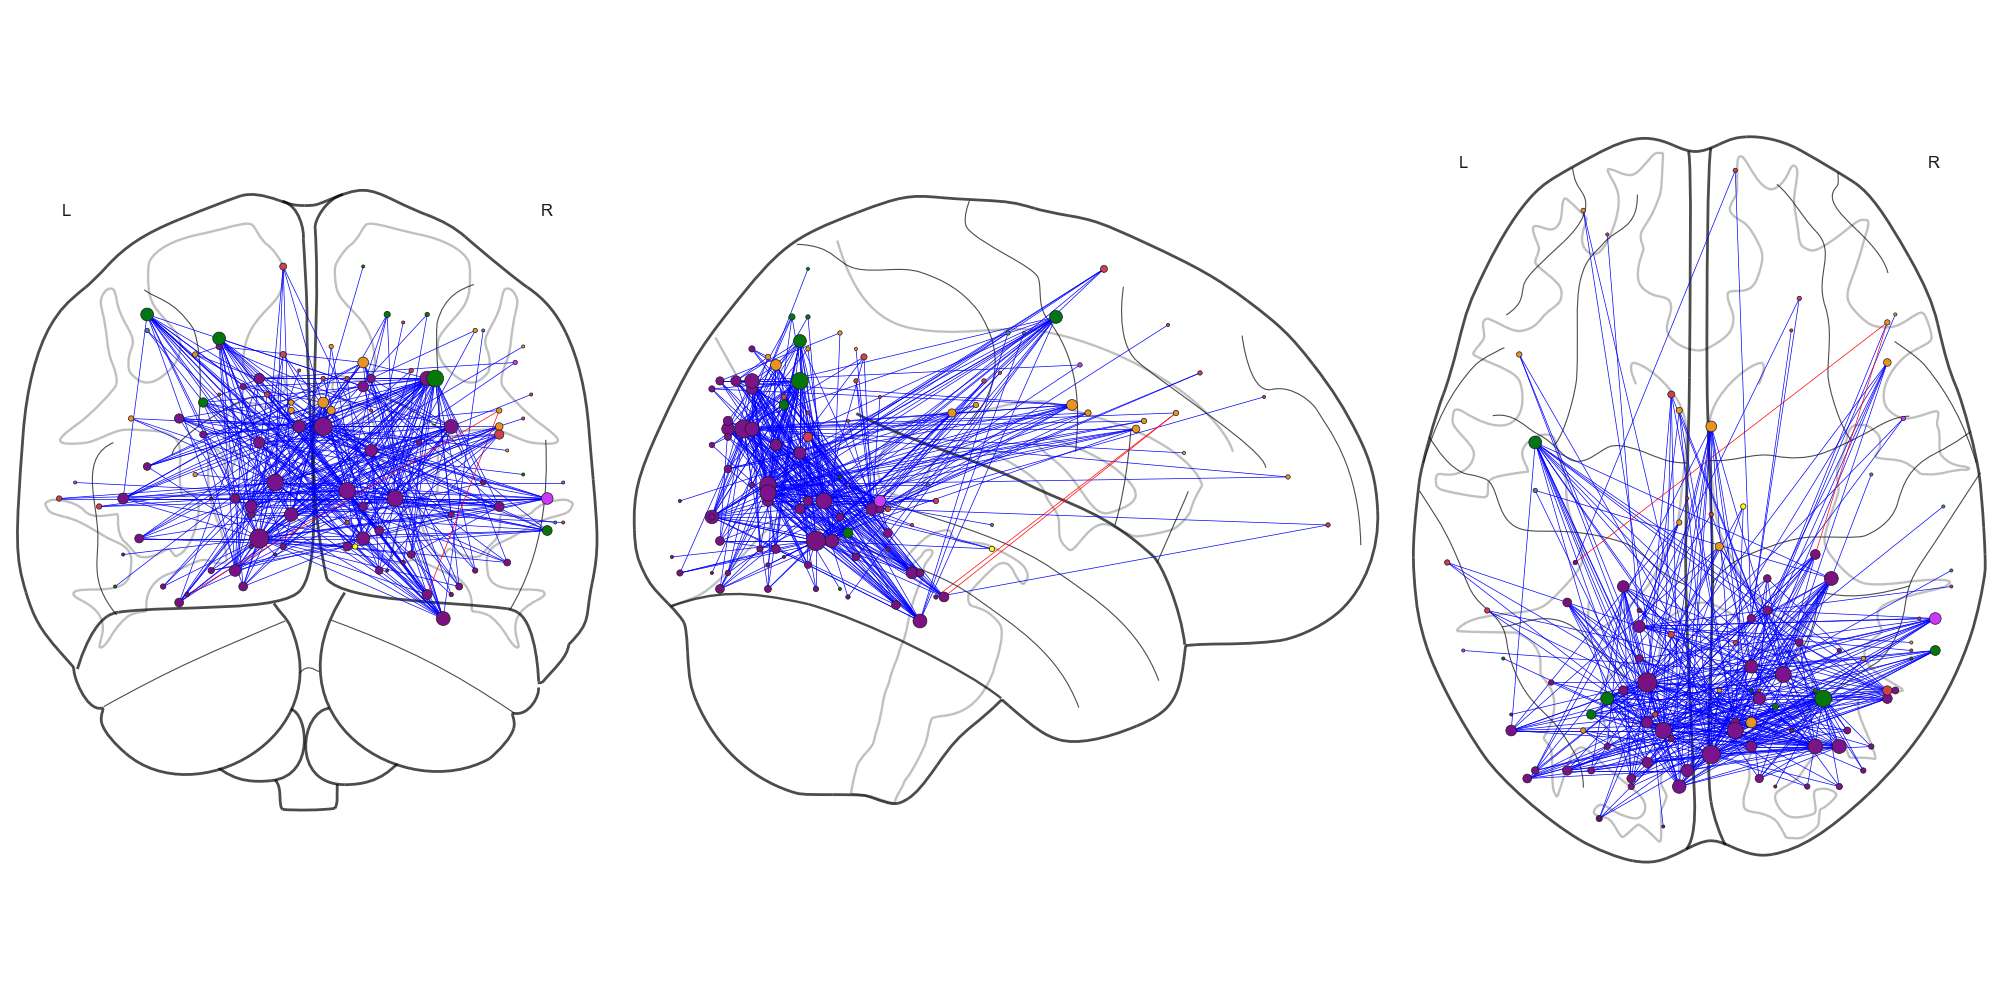

In [179]:
plot_brain_model('Images',['Vis'],nws_group_to.values,True)

In [180]:
brain_view_tab=pn.Column(pn.Row('From:',nws_group_from, background='whitesmoke'),pn.Row('To. :',nws_group_to, background='whitesmoke'),only_sel_nw,plot_brain_model)

4. Create the dashboard

In [181]:
dashboard = pn.Row(pn.Column(behav_select, get_pred_plots, pn.Tabs(('Circos Plot',circos_tab),('Brain View',brain_view_tab))), 
                   pn.Column(gather_nw_matrix))

<Figure size 640x480 with 0 Axes>

In [184]:
dashboard_server = dashboard.show(port=port_tunnel,open=False)

Launching server at http://localhost:43194


In [183]:
# Once you are done looking at matrices, you can stop the server running this cell
dashboard_server.stop()

***
# Decoding Results

In [68]:
from nilearn import masking
from nimare.stats import pearson
from glob import glob
import networkx as nx
from nxviz.utils import node_table, edge_table
from sklearn.preprocessing import MinMaxScaler

In [63]:
def create_unimodal_graph_from_matrix(data):
    assert isinstance(data,pd.DataFrame),    "++ERROR [plot_as_graph]:  input data expected to be a pandas dataframe"
    assert 'ROI_ID'     in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named ROI_ID"
    assert 'Hemisphere' in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Hemisphere"
    assert 'Network'    in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Network"
    assert 'RGB'    in data.index.names,     "++ERROR [plot_as_graph]: input data expected to have one column named RGB"
    
    # Convert input to ints (this function only works for unweigthed graphs)
    fdata          = data.copy().astype('int')
    fdata.index    = fdata.index.get_level_values('ROI_ID')
    fdata.columns  = fdata.index
    
    # Create basic Graph
    # ==================
    G = nx.from_pandas_adjacency(fdata)
    
    # Add information about hemisphere and network
    # ============================================
    hemi_attribs      = {row['ROI_ID']:row['Hemisphere'] for r,row in roi_info.iterrows()}
    nw_attribs        = {row['ROI_ID']:row['Network'] for r,row in roi_info.iterrows()}
    lab_attribs       = {row['ROI_ID']:row['ROI_Name'] for r,row in roi_info.iterrows()}
    col_attribs       = {row['ROI_ID']:row['RGB'] for r,row in roi_info.iterrows()}
    deg_attribs          = nx.degree_centrality(G)
    degree_centr_attribs = {r:v for r,v in zip(list(deg_attribs.keys()), MinMaxScaler(feature_range=(0.001,0.01)).fit_transform(np.array(list(nx.degree_centrality(G).values())).reshape(-1,1)).flatten())}
    degree_attribs       = dict(G.degree())
    nx.set_node_attributes(G,hemi_attribs,'Hemi')
    nx.set_node_attributes(G,nw_attribs,'Network')
    nx.set_node_attributes(G,lab_attribs,'ROI_Name')
    nx.set_node_attributes(G,col_attribs,'RGB')
    nx.set_node_attributes(G,degree_centr_attribs,'Degree_Centrality')
    nx.set_node_attributes(G,degree_attribs,'Degree')
    # Add edge attributes based on which model they represent
    # =======================================================
    # Count the input values
    val_counts = pd.Series(fdata.values.flatten()).value_counts()
    # Check for the presence of positive edges
    if 1 in val_counts.index:
        #fdata_pos will have 1s for edges in positive model, zero anywhere else
        fdata_pos              = fdata.copy()
        fdata_pos[fdata_pos<0] = 0 # Removing -1 from positive graph
        G_pos = nx.from_pandas_adjacency(fdata_pos)
    model_attribs = {}
    if G_pos is not None:
        for edge in G_pos.edges:
            model_attribs[edge] = 'pos'
    nx.set_edge_attributes(G,model_attribs,'Model')
    
    return G

In [56]:
nimare_metamaps_flip_folder = '/data/SFIMJGC_Introspec/prj2021_dyneusr/Resources_NiMare/LDA50/meta-analyses-RPI'
nimare_decoding_mask_path   = '/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/NiMare_Decoding_Mask_GMribbon_2023.nii.gz'
atlas_mask                  = '/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/Schaefer2018_400Parcels_7Networks_AAL2_Decoding_Template.nii.gz'

In [57]:
# Get the meta-analytic files and their names
label_files = sorted(glob(os.path.join(nimare_metamaps_flip_folder, "*_z_desc-specificity.nii.gz")))
labels = [os.path.basename(filename).split("_z")[0] for filename in label_files]

In [58]:
%%time
# Extract the data as a meta-analysis-by-voxel array
meta_data = masking.apply_mask(label_files,nimare_decoding_mask_path)
print(meta_data.shape)

(50, 119303)
CPU times: user 15.4 s, sys: 516 ms, total: 15.9 s
Wall time: 15.9 s


In [60]:
# Load Atlas Vector
atlas_vector = masking.apply_mask(atlas_mask, nimare_decoding_mask_path)
print(atlas_vector.shape)

(119303,)


In [84]:
decoding_results = {}
for BEHAVIOR in tqdm(BEHAVIOR_LIST):
    fc_pos   = pd.DataFrame(squareform(model_consensus[BEHAVIOR,'pos']),
                          index = roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index,
                          columns= roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index)
    G_pos     = create_unimodal_graph_from_matrix(fc_pos)
    G_att_pos = node_table(G_pos)
    N_rois = G_att_pos.shape[0]
    
    fc_neg   = pd.DataFrame(squareform(model_consensus[BEHAVIOR,'neg']),
                          index = roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index,
                          columns= roi_info.set_index(['ROI_ID','ROI_Name','Hemisphere','Network','RGB']).index)
    G_neg     = create_unimodal_graph_from_matrix(fc_neg)
    G_att_neg = node_table(G_neg)
    
    output_vector = np.zeros(atlas_vector.shape)
    for roi in range(N_rois):
        output_vector[atlas_vector==roi+1] = G_att_pos.loc[roi+1,'Degree'] - G_att_neg.loc[roi+1,'Degree']
    output_img  = masking.unmask(output_vector,nimare_decoding_mask_path)
    output_path = f'/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/{BEHAVIOR}_bimodal.nii'
    output_img.to_filename(output_path)
    
    # Decoding
    # ========
    # 1. Load Map (redundant in this loop)
    img_vec = masking.apply_mask(output_path, nimare_decoding_mask_path)
    # 2. Perform the correlation between the two arrays
    correlations = pearson(img_vec, meta_data)
    # 3. Create a dataframe with the correlations
    decoding_results[BEHAVIOR] = pd.DataFrame(index=labels, columns=["r"], data=correlations)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:41<00:00,  2.95s/it]


In [112]:
b = 'Words'

Row
    [0] DataFrame(DataFrame, width=500)
    [1] DataFrame(DataFrame, width=500)
    [2] Str(AxesSubplot)

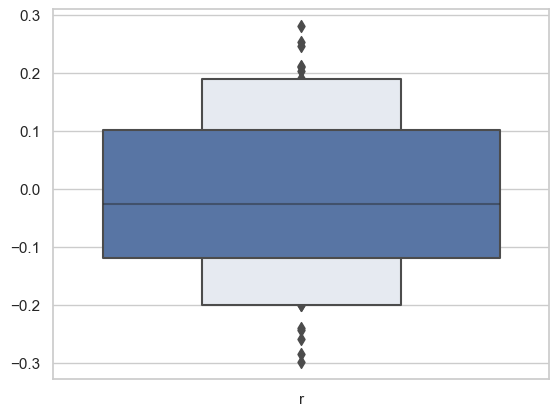

In [113]:
pn.Row(pn.pane.DataFrame(decoding_results[b].sort_values(by='r', ascending=False)[0:10],width=500),
       pn.pane.DataFrame(decoding_results[b].sort_values(by='r', ascending=False)[40:49], width=500), sns.boxenplot(decoding_results[b]))

<AxesSubplot:>

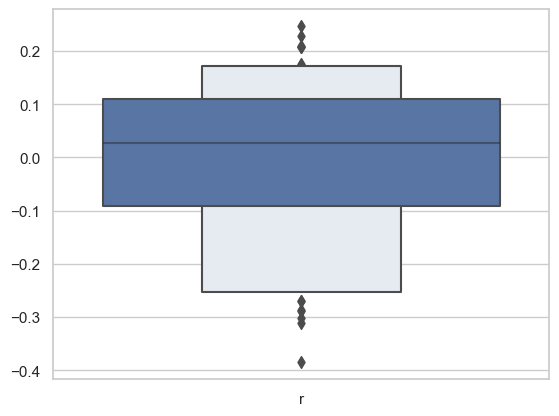

In [98]:
sns.boxenplot(decoding_results['Images'])

In [87]:
import panel as pn

In [115]:
nx.eigenvector_centrality(G_pos)

{380: 0.03914134259419639,
 379: 1.8768034984414794e-32,
 378: 0.1807606337809849,
 377: 0.1905008360421439,
 376: 0.0003596268550945491,
 375: 0.0009610228103003163,
 374: 0.0011004525925366727,
 373: 1.8768034984414794e-32,
 372: 0.036062172475704556,
 371: 0.00099324753574671,
 370: 1.8768034984414794e-32,
 369: 1.8768034984414794e-32,
 368: 4.0304048234122704e-23,
 367: 0.19876561368589846,
 366: 0.03779136649304245,
 365: 0.15584484276860042,
 364: 1.8768034984414794e-32,
 363: 1.6642200098187126e-20,
 362: 1.8768034984414794e-32,
 361: 1.8768034984414794e-32,
 360: 1.8768034984414794e-32,
 359: 1.8768034984414794e-32,
 358: 1.8768034984414794e-32,
 357: 0.0011004525925366727,
 356: 0.021367299337971036,
 355: 1.8768034984414794e-32,
 354: 1.8768034984414794e-32,
 353: 0.02229574922122738,
 352: 1.8768034984414794e-32,
 351: 1.8768034984414794e-32,
 350: 0.08099783957221596,
 349: 0.005917399699164151,
 348: 0.040618218877411454,
 347: 1.8768034984414794e-32,
 346: 0.0792881308392

INFO:bokeh.server.views.ws:WebSocket connection closed: code=None, reason=None


In [64]:
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv
from holoviews import dim, opts
from nilearn.plotting import plot_matrix
from matplotlib import patches
import matplotlib.pyplot as plt
import networkx as nx
from nxviz.utils import node_table, edge_table
from nxviz import plots, nodes, edges, lines

nw_color_map = {'LH-Vis':'purple',      'RH-Vis':'purple','Vis':'purple',
                   'LH-SomMot':'lightblue'  ,'RH-SomMot':'lightblue','SomMot':'lightblue',
                   'LH-DorsAttn':'green'    ,'RH-DorsAttn':'green','DorsAttn':'green',
                   'LH-SalVentAttn':'violet','RH-SalVentAttn':'violet','SalVentAttn':'violet',
                   'LH-Cont':'orange','RH-Cont':'orange','Cont':'orange',
                   'LH-Default':'red','RH-Default':'red','Default':'red',
                   'LH-Subcortical':'yellow',      'RH-Subcortical':'yellow','Subcortical':'yellow',
                   'LH-Limbic':'lightgreen',      'RH-Limbic':'lightgreen','Limbic':'lightgreen'}
hm_color_map = {'LH':'grey','RH':'darkgrey'}

In [72]:
def get_node_positions(roi_info,r=0.5,c_x=0.0,c_y=0.0,hemi_gap=5):
    # Get list of networks
    # ====================
    networks    = list(roi_info['Network'].unique())
    # Create Node Positions
    # =====================
    # 1. Max number of nodes per networks in one or another hemisphere
    max_num_nodes_per_network = {}
    for nw in networks:
        aux = roi_info[roi_info['Network']==nw]
        max_num_nodes_per_network[nw] = np.max([aux[aux['Hemisphere']=='LH'].shape[0],aux[aux['Hemisphere']=='RH'].shape[0]])
    # 2. Number of locations to choose from in circle: 2 * (Max_PerNetwork + Pads on both ends)
    n_locations = 2 * (np.array([max_num_nodes_per_network[nw] for nw in max_num_nodes_per_network.keys()]).sum() + 2 * hemi_gap)
    
    # 3. Evently distributed angels (in radians) across the circle
    avail_angles = np.linspace(0,2*np.pi,n_locations)
    avail_angles = np.roll(avail_angles,-int(n_locations/4))
    
    # 4. Convert the angles to (x,y) locations
    positions = []
    for t in avail_angles:
        x = r*np.cos(t) + c_x
        y = r*np.sin(t) + c_y
        positions.append(np.array([x,y]))
    positions_per_hemi = {'RH': positions[0:int(n_locations/2)], 
                          'LH': positions[int(n_locations/2)::][::-1]}
    # 5. Create Final Layout Object
    G_circos_layout = {}
    for hm in ['LH','RH']:
        index = hemi_gap
        for nw in networks:
            index_init = index 
            aux = roi_info[(roi_info['Network']==nw) & (roi_info['Hemisphere']==hm)]
            for n,node in enumerate(list(aux['ROI_ID'])):
                G_circos_layout[node] = positions_per_hemi[hm][index]
                index = index + 1
            index = index_init + max_num_nodes_per_network[nw]
    return G_circos_layout
   
def plot_as_circos(data,roi_info,figsize=(10,10),edge_weight=2,title=None, hemi_gap=5, show_pos=True, show_neg=True):
    # Check inputs meet expectations
    assert isinstance(data,pd.DataFrame), "++ERROR [plot_as_circos]: input data expected to be a pandas dataframe"
    assert 'ROI_ID'     in data.index.names, "++ERROR [plot_as_circos]: roi_info expected to have one column named ROI_ID"
    assert 'Hemisphere' in roi_info.columns, "++ERROR [plot_as_circos]: roi_info expected to have one column named Hemisphere"
    assert 'Network'    in roi_info.columns, "++ERROR [plot_as_circos]: roi_info expected to have one column named Network"
    assert 'RGB'    in roi_info.columns, "++ERROR [plot_as_circos]: roi_info expected to have one column named RGB"

    # Convert input to ints (this function only works for unweigthed graphs)
    fdata          = data.copy().astype('int')
    fdata.index    = fdata.index.get_level_values('ROI_ID')
    fdata.columns  = fdata.index
    # Create None objects for the graphs
    G_pos, G_neg, G = None, None, None
    # Count the input values
    val_counts = pd.Series(fdata.values.flatten()).value_counts()
    # Check for the presence of positive edges
    if 1 in val_counts.index:
        fdata_pos              = fdata.copy()
        #fdata_pos.index        = fdata.index.get_level_values('ROI_ID')
        #fdata_pos.columns      = fdata.index.get_level_values('ROI_ID')
        fdata_pos[fdata_pos<0] = 0 # Removing -1 from positive graph
        G_pos = nx.from_pandas_adjacency(fdata_pos)
    # Check for the present of negative edges
    if -1 in val_counts.index:
        fdata_neg              = fdata.copy()
        #fdata_neg.index        = fdata.index.get_level_values('ROI_ID')
        #fdata_neg.columns      = fdata.index.get_level_values('ROI_ID')
        fdata_neg[fdata_neg>0] = 0 # Removing 1 from negative graph
        G_neg = nx.from_pandas_adjacency(fdata_neg)
    # Create Graph with all nodes (for positioning purposes - edges do not matter)
    
    G             = nx.from_pandas_adjacency(fdata+100) # Ensure we have a graph with all nodes
    # Add information about positive or negative edge
    model_attribs = {}
    if G_pos is not None:
        for edge in G_pos.edges:
            model_attribs[edge] = 'pos'
    if G_neg is not None:
        for edge in G_neg.edges:
            model_attribs[edge] = 'neg'
    nx.set_edge_attributes(G,model_attribs,'Model')
    # Add information about hemisphere and network
    hemi_attribs = {row['ROI_ID']:row['Hemisphere'] for r,row in roi_info.iterrows()}
    nw_attribs   = {row['ROI_ID']:row['Network'] for r,row in roi_info.iterrows()}
    nx.set_node_attributes(G,hemi_attribs,'Hemi')
    nx.set_node_attributes(G,nw_attribs,'Network')
    # Obtain Node Positions
    pos =  get_node_positions(roi_info, hemi_gap=hemi_gap)
    # Node Styling
    nt  = node_table(G)
    node_color = roi_info.set_index('ROI_ID')['RGB']
    node_alpha = pd.Series(1.0, index=node_color.index)
    node_size  = pd.Series(0.01, index=node_color.index)
    # Positive Edges Styling
    if G_pos is not None:
        pos_et         = edge_table(G_pos)
        pos_et_color   = pd.Series('red', index=range(pos_et.shape[0]))
        pos_lw         = edge_weight*pos_et["weight"] 
        pos_alpha      = pd.Series(0.5, index=range(pos_et.shape[0]))
    # Negative Edges Styling
    if G_neg is not None:
        neg_et         = edge_table(G_neg)
        neg_et_color   = pd.Series('lightblue', index=range(neg_et.shape[0]))#edges.edge_colors(et, nt=None, color_by=None, node_color_by=None)
        neg_lw         = edge_weight*neg_et["weight"] 
        neg_alpha      = pd.Series(0.3, index=range(neg_et.shape[0]))
    #Create plot
    fig, ax = plt.subplots(1,1,figsize=figsize)
    patches = nodes.node_glyphs( nt, pos, node_color=node_color, alpha=node_alpha, size=node_size, **{'edgecolor':None, 'linewidth':0})
    for patch in patches: 
        ax.add_patch(patch)
    if (G_pos is not None) & (show_pos is True): 
        patches = lines.circos( pos_et, pos, edge_color=pos_et_color, alpha=pos_alpha, lw=pos_lw, aes_kw={"fc": "none"} ) 
        for patch in patches: 
            ax.add_patch(patch)
    if (G_neg is not None) & (show_neg is True):
        patches = lines.circos( neg_et, pos, edge_color=neg_et_color, alpha=neg_alpha, lw=neg_lw, aes_kw={"fc": "none"} ) 
        for patch in patches: 
            ax.add_patch(patch)
    if title is not None:
       plt.title(title)
    plots.rescale(G) 
    plots.aspect_equal()
    plots.despine()
    plt.close()
    return fig

In [73]:
behavior='Vigilance'

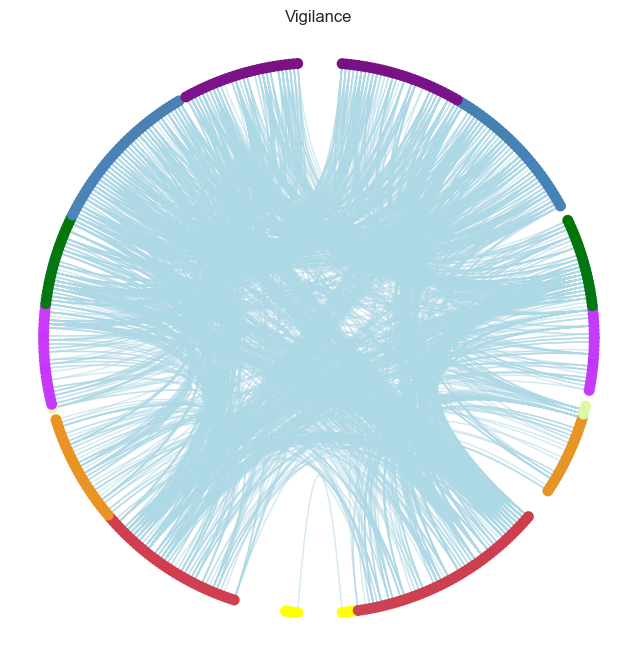

In [76]:
plot_as_circos(model_consensus_to_plot[behavior],roi_info,figsize=(8,8),edge_weight=1, title=behavior, show_pos=False)

In [130]:
def hvplot_fc_nwlevel(data,mode='percent',clim_max=None,clim_min=0, cmap='viridis', title='', add_net_colors=False):
    """
    This function plots a summary view of how many within- and between- network connections
    are significantly different in a given contrast.
    
    Inputs:
    data: this is dataframe with the outputs from NBS or a combination of those. It is expected to only contains 0,1 and -1 values.
          it is also expected to be indexed by a multi-index with one level having the name 'Network' that contains the name of the
          networks. This is used for plotting and counting purposes, so it is very important to adhere to this requirement.
    
    mode: instruct to report results in terms of absolute number of connections 'count' or percentage of possible connections 'percent'.
    
    clim_max: max value for the colorbar. If unset, it will be automatically set to the 95% percentile.
    
    clim_min: min value for the colorbar. It unset, it will be automatically set to zero.
    
    cmap: colormap. [default = viridis]

    title: title for the plot. [default = '']
    
    add_net_colors: flag to remove substitute text labels in the X-axis by colored segments denoting the different networks.
    """
    assert mode in ['percent','count']
    data         = data.copy()
    networks     = list(data.index.get_level_values('Network').unique())
    num_networks = len(networks)
    num_sig_cons = pd.DataFrame(index=networks, columns=networks)
    pc_sig_cons  = pd.DataFrame(index=networks, columns=networks)
    for n1 in networks:
        for n2 in networks:
            aux = data.loc[data.index.get_level_values('Network')==n1,data.columns.get_level_values('Network')==n2]
            if n1 == n2:
                ncons = aux.shape[0] * (aux.shape[0] -1 ) / 2
                num_sig_cons.loc[n1,n2] = int(aux.sum().sum()/2) 
                pc_sig_cons.loc[n1,n2]  = 100 * num_sig_cons.loc[n1,n2] / ncons
            else:
                ncons = aux.shape[0] * aux.shape[1] 
                num_sig_cons.loc[n1,n2] = int(aux.sum().sum())
                pc_sig_cons.loc[n1,n2]  = 100 * num_sig_cons.loc[n1,n2] / ncons
    num_sig_cons = num_sig_cons.infer_objects()
    pc_sig_cons  = pc_sig_cons.infer_objects()
    #Advance plotting mode with colored segments in the horizontal axis.
    if add_net_colors:
       # Create Y axis ticks and labels
       y_ticks_info = list(tuple(zip(range(num_networks), networks))) 
       # Create Network Colorbar
       if add_net_colors:
           net_segments_y = hv.Segments((tuple(np.arange(num_networks)+1),tuple(np.ones(num_networks)-1.5),
                                      tuple(np.arange(num_networks)),tuple(np.ones(num_networks)-1.5), networks),vdims='Networks').opts(cmap=nw_color_map, color=dim('Networks'), line_width=10,show_legend=False)    
    
       # Remove axes from data
       if mode=='percent':
           matrix_to_plot              = pd.DataFrame(pc_sig_cons.values)
           cbar_title = 'Percent of Connections:'
       else:
           matrix_to_plot              = pd.DataFrame(num_sig_cons.values)
           cbar_title = 'Number of Connections:'
       matrix_to_plot.index        = np.arange(matrix_to_plot.shape[0], dtype=int)
       matrix_to_plot.columns      = np.arange(matrix_to_plot.shape[1], dtype=int)
       #return matrix_to_plot 
       if clim_max is None:
          clim_max = matrix_to_plot.quantile(.95).max()
       heatmap = matrix_to_plot.round(1).hvplot.heatmap(aspect='square', clim=(0,clim_max), cmap=cmap, 
                                                        title=title, ylim=(-.5,num_networks-.5), yticks= y_ticks_info, xaxis=None).opts(xrotation=90,colorbar_opts={'title':cbar_title})
       plot = heatmap * hv.Labels(heatmap).opts(opts.Labels(text_color='white', text_font_size='10pt'))
       plot = plot * net_segments_y
    
    #Basic Plotting Mode
    else:
        if mode=='percent':
            if clim_max is None:
                clim_max = pc_sig_cons.quantile(.95).max()
            #value_dimension = hv.Dimension('Values', value_format=lambda x: '%.1f %' % x)
            heatmap = pc_sig_cons.round(1).hvplot.heatmap(aspect='square', clim=(0,clim_max), cmap=cmap, title=title).opts(xrotation=90, colorbar_opts={'title':'Percent of Connections:'})
            #plot = heatmap * hv.Labels(pc_sig_cons.round(1).values,vdims=value_dimension).opts(opts.Labels(text_color='white', text_font_size='10pt')) 
            plot = heatmap * hv.Labels(heatmap).opts(opts.Labels(text_color='white', text_font_size='10pt')) 

        if mode=='count':
            if clim_max is None:
                clim_max = num_sig_cons.quantile(.95).max()
            heatmap  = num_sig_cons.round(1).hvplot.heatmap(aspect='square', clim=(clim_min,clim_max), cmap=cmap, title=title ).opts(xrotation=90,colorbar_opts={'title':'Number of Connections:'})
            plot = heatmap * hv.Labels(heatmap).opts(opts.Labels(text_color='white', text_font_size='10pt'))
    #Return plot
    return plot   

In [133]:
hvplot_fc_nwlevel(model_consensus_to_plot[behavior], add_net_colors=True, cmap='Reds')

:Overlay
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .Labels.I   :Labels   [columns,index]   (value)
   .Segments.I :Segments   [x0,y0,x1,y1]   (Networks)

In [324]:
list(set(['Vis','Default']+['Vis','Control']))

['Default', 'Control', 'Vis']

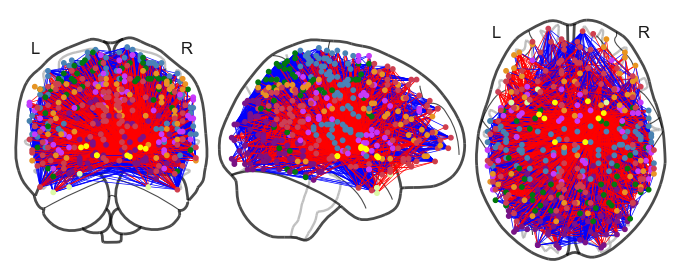

In [161]:
plot_connectome(adjacency_matrix=model_consensus_to_plot['Vigilance'], 
                node_coords=roi_info[['pos_R', 'pos_A','pos_S']],
                node_color=roi_info['RGB'],
                node_size=10,
                edge_kwargs={'linewidth':0.5})

In [176]:
model_consensus_to_plot['Vigilance'] #.loc[:,:,:,['Vis','Default']].xs('Vis','Default',level='Network', axis=1)  #[:,:,:,['Vis','Default']]

,,,ROI_ID,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
,,,ROI_Name,LH_Vis_1,LH_Vis_2,LH_Vis_3,LH_Vis_4,LH_Vis_5,LH_Vis_6,LH_Vis_7,LH_Vis_8,LH_Vis_9,LH_Vis_10,...,RH_Default_pCunPCC_4,RH_Default_pCunPCC_5,RH_Default_pCunPCC_6,RH_Default_pCunPCC_7,RH_Default_pCunPCC_8,RH_Default_pCunPCC_9,RH_Subcortical_Caudate,RH_Subcortical_Putamen,RH_Subcortical_Pallidum,RH_Subcortical_Thalamus
,,,Hemisphere,LH,LH,LH,LH,LH,LH,LH,LH,LH,LH,...,RH,RH,RH,RH,RH,RH,RH,RH,RH,RH
,,,Network,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,...,Default,Default,Default,Default,Default,Default,Subcortical,Subcortical,Subcortical,Subcortical
ROI_ID,ROI_Name,Hemisphere,Network,,,,,,,,,,,,,,,,,,,,,
1,LH_Vis_1,LH,Vis,0,0,0,-1,-1,-1,0,-1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,LH_Vis_2,LH,Vis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,LH_Vis_3,LH,Vis,0,0,0,0,-1,-1,-1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,LH_Vis_4,LH,Vis,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,LH_Vis_5,LH,Vis,-1,0,-1,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [201]:
sel_nws = ['Default']
aux = model_consensus_to_plot['Vigilance'].copy()
aux.index=aux.index.get_level_values('Network')
aux.columns=aux.index.get_level_values('Network')
aux2 = pd.DataFrame(0, index=aux.index, columns=aux.columns)
aux2.loc[sel_nws, sel_nws] = aux.loc[sel_nws, sel_nws]

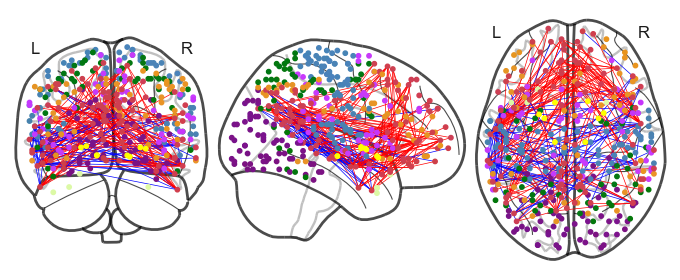

In [206]:
plot_connectome(adjacency_matrix=aux2, 
                node_coords=roi_info[['pos_R', 'pos_A','pos_S']],
                node_color=roi_info['RGB'],
                node_size=10,
                edge_kwargs={'linewidth':0.5})

In [204]:
aux

Network,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,Vis,...,Default,Default,Default,Default,Default,Default,Subcortical,Subcortical,Subcortical,Subcortical
Network,,,,,,,,,,,,,,,,,,,,,
Vis,0,0,0,-1,-1,-1,0,-1,0,0,...,0,0,0,0,0,0,0,1,0,1
Vis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Vis,0,0,0,0,-1,-1,-1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
Vis,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Vis,-1,0,-1,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Default,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Subcortical,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Subcortical,1,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
